<a href="https://colab.research.google.com/github/eshansurendra/EN3160_Assignment_03/blob/main/A03_E03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 03

### Download Data

In [1]:
# Step 1: Download the zip file
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

# Step 2: Extract the zip file
!unzip hymenoptera_data.zip -d ./hymenoptera_data

# Verify extraction by listing the directory contents
!ls ./hymenoptera_data

--2024-11-14 15:00:29--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.65.25.85, 18.65.25.112, 18.65.25.126, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.65.25.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   203MB/s    in 0.2s    

2024-11-14 15:00:29 (203 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: ./hymenoptera_data/hymenoptera_data/
   creating: ./hymenoptera_data/hymenoptera_data/train/
   creating: ./hymenoptera_data/hymenoptera_data/train/ants/
  inflating: ./hymenoptera_data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: ./hymenoptera_data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: ./hymenoptera_data/hymenoptera_data/train/ants/1095476100_3906d8a

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

### Load Data

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Visualize images

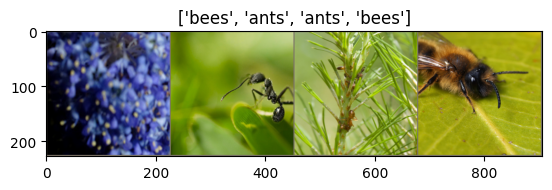

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training the model

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Store losses and accuracies for plotting
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        # Save initial model parameters
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluation mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward pass and optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Update statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                # Step the learning rate scheduler after each epoch
                if phase == 'train':
                    scheduler.step()

                # Compute average loss and accuracy
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                # Store metrics for plotting
                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accuracies.append(epoch_acc.item())
                else:
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc.item())

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Deep copy the model if it has the best validation accuracy
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        # Training time
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        # Load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    # Plotting the loss and accuracy
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

    return model

### Visualizing the model predictions

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

In [12]:
# Load the pre-trained ResNet18 model trained on ImageNet
# Using ResNet18 with pre-trained weights from ImageNet for transfer learning
resnet18_model = models.resnet18(weights='IMAGENET1K_V1')

# Modify the fully connected layer to match the number of classes in the hymenoptera dataset (2 classes)
num_features = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(num_features, 2)  # Changing output layer to 2 classes

# Move the model to the device (GPU if available)
resnet18_model = resnet18_model.to(device)

# Define the loss function (cross-entropy for multi-class classification)
loss_function = nn.CrossEntropyLoss()

# Set up the optimizer to optimize all parameters for fine-tuning
optimizer_fine_tune = optim.SGD(resnet18_model.parameters(), lr=0.001, momentum=0.9)

# Set up a learning rate scheduler to decay the learning rate by 0.1 every 7 epochs
learning_rate_scheduler = lr_scheduler.StepLR(optimizer_fine_tune, step_size=7, gamma=0.1)

### Train and evaluate

Epoch 1/25
----------
train Loss: 0.6653 Acc: 0.6680
val Loss: 0.8447 Acc: 0.6993

Epoch 2/25
----------
train Loss: 0.5015 Acc: 0.8115
val Loss: 0.3735 Acc: 0.8627

Epoch 3/25
----------
train Loss: 0.6988 Acc: 0.7049
val Loss: 0.1564 Acc: 0.9542

Epoch 4/25
----------
train Loss: 0.6449 Acc: 0.7459
val Loss: 0.3446 Acc: 0.8758

Epoch 5/25
----------
train Loss: 0.3228 Acc: 0.8525
val Loss: 0.2522 Acc: 0.8627

Epoch 6/25
----------
train Loss: 0.4533 Acc: 0.8197
val Loss: 0.4353 Acc: 0.8497

Epoch 7/25
----------
train Loss: 0.4873 Acc: 0.8115
val Loss: 0.3038 Acc: 0.8889

Epoch 8/25
----------
train Loss: 0.3264 Acc: 0.8402
val Loss: 0.2144 Acc: 0.9281

Epoch 9/25
----------
train Loss: 0.2920 Acc: 0.8770
val Loss: 0.2462 Acc: 0.9085

Epoch 10/25
----------
train Loss: 0.2993 Acc: 0.8934
val Loss: 0.2318 Acc: 0.9216

Epoch 11/25
----------
train Loss: 0.3223 Acc: 0.8525
val Loss: 0.2160 Acc: 0.9346

Epoch 12/25
----------
train Loss: 0.3066 Acc: 0.8852
val Loss: 0.2273 Acc: 0.9085

E

<ipython-input-10-1cda09baf8e4>:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


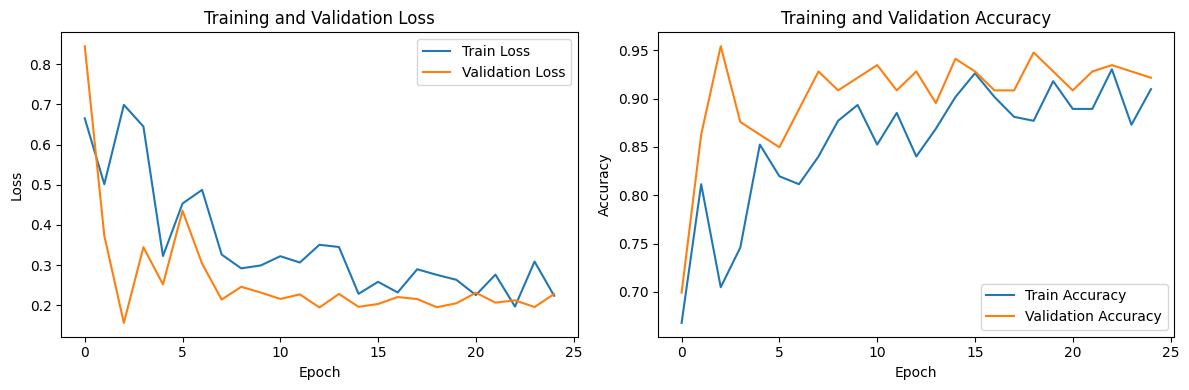

In [13]:
trained_model = train_model(
    resnet18_model,
    loss_function,
    optimizer_fine_tune,
    learning_rate_scheduler,
    num_epochs=25
)

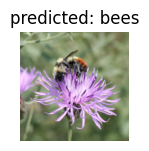

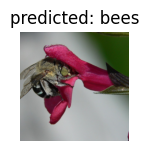

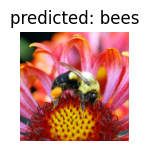

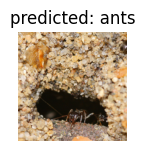

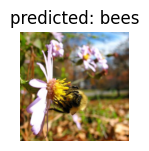

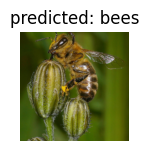

In [14]:
visualize_model(trained_model)

## ConvNet as fixed feature extractor

In [15]:
# Load the pre-trained ResNet18 model
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Freeze all model parameters to prevent them from being updated during training
for param in model_conv.parameters():
    param.requires_grad = False

# Modify the fully connected layer to output 2 classes (bees and ants)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device (GPU or CPU)
model_conv = model_conv.to(device)

# Define the loss function (cross-entropy loss for classification)
criterion = nn.CrossEntropyLoss()

# Set up the optimizer to only update parameters of the final layer
# The parameters of the other layers are frozen (i.e., `requires_grad=False`)
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Set up the learning rate scheduler to reduce the learning rate by a factor of 0.1 every 7 epochs
lr_scheduler_conv = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

Epoch 1/25
----------
train Loss: 0.5601 Acc: 0.7090
val Loss: 0.2166 Acc: 0.9085

Epoch 2/25
----------
train Loss: 0.5053 Acc: 0.7582
val Loss: 0.1846 Acc: 0.9477

Epoch 3/25
----------
train Loss: 0.3999 Acc: 0.8361
val Loss: 0.4528 Acc: 0.7974

Epoch 4/25
----------
train Loss: 0.5446 Acc: 0.7582
val Loss: 0.1791 Acc: 0.9477

Epoch 5/25
----------
train Loss: 0.3967 Acc: 0.8361
val Loss: 0.1794 Acc: 0.9346

Epoch 6/25
----------
train Loss: 0.3467 Acc: 0.8443
val Loss: 0.1672 Acc: 0.9477

Epoch 7/25
----------
train Loss: 0.5058 Acc: 0.7992
val Loss: 0.1454 Acc: 0.9477

Epoch 8/25
----------
train Loss: 0.3309 Acc: 0.8443
val Loss: 0.1531 Acc: 0.9542

Epoch 9/25
----------
train Loss: 0.3615 Acc: 0.8689
val Loss: 0.1741 Acc: 0.9281

Epoch 10/25
----------
train Loss: 0.3575 Acc: 0.8361
val Loss: 0.1455 Acc: 0.9542

Epoch 11/25
----------
train Loss: 0.3615 Acc: 0.8443
val Loss: 0.1542 Acc: 0.9542

Epoch 12/25
----------
train Loss: 0.4351 Acc: 0.7951
val Loss: 0.1676 Acc: 0.9346

E

<ipython-input-10-1cda09baf8e4>:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


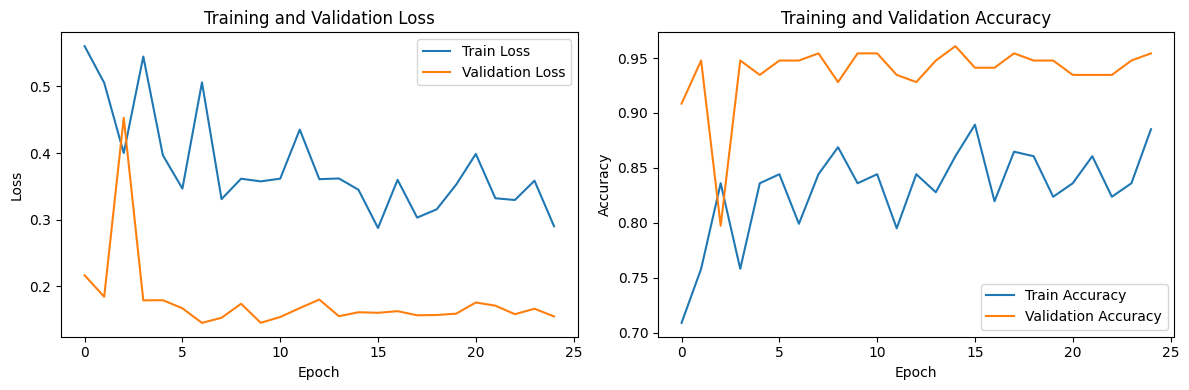

In [16]:
# Train the model using the fine-tuned ResNet18 (as a feature extractor)
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         lr_scheduler_conv, num_epochs=25)


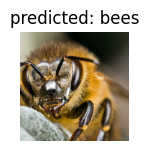

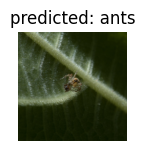

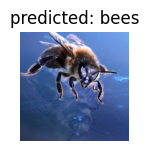

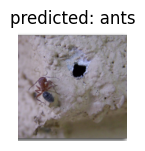

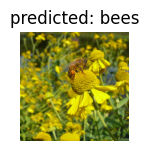

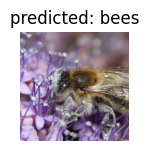

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Discussion: Transfer Learning with ResNet18 on Hymenoptera Dataset

### 1. Fine-Tuning the ConvNet
In the fine-tuning approach, we modify the pre-trained ResNet18 model by updating the last fully connected layer to classify the Hymenoptera dataset with 2 classes. The model's weights are initialized from the ImageNet dataset, and all layers, including the convolutional layers, are fine-tuned during training.

#### Key Observations:
- The model achieved **best validation accuracy of 95.42%**.
- While training accuracy improved steadily, validation accuracy showed a slight fluctuation in the final epochs.
- The training time was **1 minute and 22 seconds** for 25 epochs, reflecting efficient convergence with the fine-tuning approach.

The fine-tuning approach allowed the model to adapt more specifically to the Hymenoptera dataset. By updating all layers during training, the model could learn to fine-tune features specific to the task at hand, achieving high accuracy.

---

### 2. ConvNet as a Fixed Feature Extractor
In this approach, we freeze the weights of the convolutional layers and only train the newly added fully connected layer. This allows the pre-trained feature extraction layers to remain fixed, and the model learns to classify the data based on the features already learned from ImageNet.

#### Key Observations:
- The model achieved **best validation accuracy of 96.08%**.
- The train accuracy was lower compared to the fine-tuning approach, but the validation accuracy continued to improve throughout the training.
- The training time was **1 minute and 15 seconds**, slightly less than the fine-tuning approach.

Using the ConvNet as a fixed feature extractor allowed the model to leverage the pre-trained features and learn an appropriate classification head for the Hymenoptera dataset. The results indicate that this method can also achieve high performance, with slightly better validation accuracy than fine-tuning in this case.

---

### Conclusion
Both approaches—fine-tuning the ConvNet and using it as a fixed feature extractor—produced strong results, with the **best validation accuracy** being **95.42% for fine-tuning** and **96.08% for the fixed feature extractor** method. While fine-tuning allows the model to learn more task-specific features, the fixed feature extractor approach performs nearly as well, with the benefit of reduced training time.
